# Overview

Approximately 2,000 records of randomly selected Amazon.com Product Reviews were processed through [Originality.AI](originality.ai) to determine the probability of AI Content. A series of experiments were performed on this data, to get more information about the relationship between the AI Content and the different features of the reviews. The purpose of the experiments in this notebook is to answer the following questions:

1. Is there a correlation between the severity of a review and AI Content? Or in other words, are more extreme Reviews (5 - very good or 1 - very bad) more or less likely to have `aiContent`?
    
2. Is there any relationship between the helpfulness of a Review (i.e. the number of votes of 'people' found this review helpful) and its `aiContent`?

3. Has there been an increase in `aiContent` in Amazon reviews since the introduction of Chat GPT in the last Quarter of 2022? 

In [1]:
# import custom helper functions
# also imports the usual package libraries like pandas, numpy, etc
from helperfiles import *        
import time

# The Data 

Approximately 27K records of raw data were retrieved from Amazon. The data was cleaned using the standard processes, and customer sensitive information was removed. Approximately 2K were then processed through [Originality.AI](originality.ai)'s state-of-the-art AI detector to provide viable records for analysis. Statistical tests were performed on the dataset to confirm that the data used for the analysis, was representative of the original raw data. See Appendix for this test.

In [2]:
df = get_data_for_analysis()
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  2120 non-null   datetime64[ns]
 1   isVerified            2120 non-null   bool          
 2   ratingScore           2120 non-null   int64         
 3   reviewDescription     2120 non-null   object        
 4   totalCategoryRatings  2120 non-null   int64         
 5   totalCategoryReviews  2120 non-null   int64         
 6   productGroup          2120 non-null   object        
 7   averageRating         2120 non-null   float64       
 8   goodreadsRating       250 non-null    float64       
 9   helpfulCount          2120 non-null   int64         
 10  aiContent             2120 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(3), int64(4), object(2)
memory usage: 167.8+ KB


None

,date,isVerified,ratingScore,reviewDescription,totalCategoryRatings,totalCategoryReviews,productGroup,averageRating,goodreadsRating,helpfulCount,aiContent
0,2020-09-10,False,4,You kind of know when you buy something like S...,955,126,Jewelry,4.6,NaN,1,0.0004
1,2020-09-05,False,4,These earring are beautiful . The Swarovski Ci...,955,126,Jewelry,4.6,NaN,1,0.0001
2,2022-01-30,True,3,Comme pour une autre paire commandée ces jours...,358,50,Jewelry,4.6,NaN,12,0.0010
3,2022-01-30,True,3,"Servizio Amazon impeccabile, spedizione veloci...",358,50,Jewelry,4.6,NaN,1,0.3676
4,2022-10-22,True,2,I bought this for my 8 year old niece because ...,65,27,Jewelry,4.6,NaN,11,0.0015


# The Experiments

## Does `ratingSeverity` correlate with `aiContent`?

This experiment investigates if  a review that is extremely rated (1 or 5) is more likely to have `aiContent` than a moderately rated (2, 3 or 4) review. 

### Process: 

1. the reviews are categorized into a `ratingSeverity` binary feature: Extreme (1s and 5s) or Moderate (2s, 3s, 4s)
2. visual anslysis is performed by plotting this feature against the `aiContent`.
3. statistical analysis is performed by the ANOVA (Analysis of Variance), the common method of comparing a categorical feature against a numerical feature.

In [3]:
from scipy.stats import spearmanr, kendalltau, pearsonr
import math

In [4]:
# convert ratingScore into ratingSeverity category 'extreme', and 'moderate'
def severe(ratingScore):
    ratingSeverity = 'Extreme (5 or 1)' if (ratingScore==5 or ratingScore==1) else \
                     'Moderate (2, 3, or 4)' 
    return ratingSeverity
df['ratingSeverity'] = df['ratingScore'].apply(lambda x: severe(x))
df.head(3)

,date,isVerified,ratingScore,reviewDescription,totalCategoryRatings,totalCategoryReviews,productGroup,averageRating,goodreadsRating,helpfulCount,aiContent,ratingSeverity
0,2020-09-10,False,4,You kind of know when you buy something like S...,955,126,Jewelry,4.6,NaN,1,0.0004,"Moderate (2, 3, or 4)"
1,2020-09-05,False,4,These earring are beautiful . The Swarovski Ci...,955,126,Jewelry,4.6,NaN,1,0.0001,"Moderate (2, 3, or 4)"
2,2022-01-30,True,3,Comme pour une autre paire commandée ces jours...,358,50,Jewelry,4.6,NaN,12,0.0010,"Moderate (2, 3, or 4)"


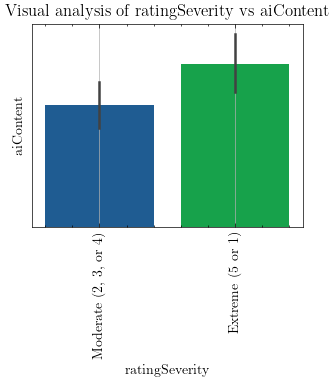

p value is 0.035614.
aiContent and ratingSeverity are correlated.


In [5]:
# call the categorical testing function that plots the graph and performs the ANOVA test
categorical_testing(df, 'ratingSeverity')

### Analysis of other categorical features

Other categorical features were tested/analyzed:

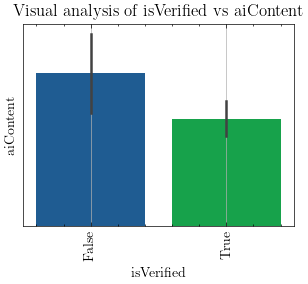

p value is 0.023953.
aiContent and isVerified are correlated.


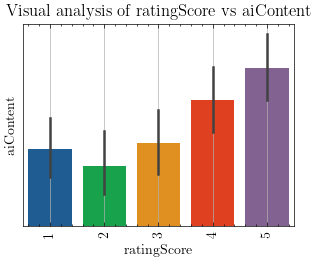

p value is 0.000317.
aiContent and ratingScore are correlated.


In [6]:
categorical_cols = [
    # 'productGroup', 
    'isVerified', 
    'ratingScore'
]
for col in categorical_cols:
    categorical_testing(df, col)

### Summary of Findings
* Extreme reviews (rated 1 and 5) are more likely to be detected with AI Content than moderate reviews (2, 3, 4).

* Verified reviews are less likely to be detected with AI Content.

* `productGroup` relationship to AI Content is not conclusive because of the overlapping between categories (e.g. a jewelry box item can be tagged under both Jewelry and Travel)

## Helpfulness votes and AI Content

`helpfulCount` represents the votes that are given to a review by logged-in Amazon subscribers. This experiment tests if there is any correlation between a review being widely regarded as helpful and its `aiContent`. It also considers the impact `days` i.e. the age of the review has on its `helpfulCount` and therefore the correlation with `aiContent`.

### Process:

1. Standardizing to `helpfulScore`: Due to the wide variety of the sample data, the range of values of the `helpfulCount` of each record is extreme. To properly analyze this relationship, the `helpfulCount` has to be standardized against the total Ratings and total Reviews of the product item that is being reviewed.
2. Visualizing the relationship between `helpfulScore` and `aiContent` with a scatter plot.
3. Statistics testing with the 3 common correlation tests (Spearman's Rho, Kendall Tau, and Pearson R) to check for a correlation between these features.
4. Extracting the age of the review into a new feature `days`.
5. Performating visual and statistical analysis of `days` and `helpfulScore` by the methods describes in (2) and (3)
6. Creating an Ordinary Leasts Squares `stats.OLS` model to analyze the relationship between the three features, and check for dependencies.

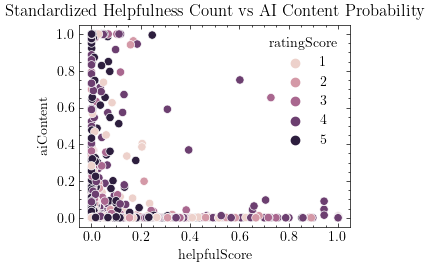


Results of the Spearman test: Correlation is -0.09055202781697204, with a p-value of 0.00003.
aiContent and helpfulScore are correlated.

Results of the Kendall Tau test: Correlation is -0.06326488407625118, with a p-value of 0.00003.
aiContent and helpfulScore are correlated.

Results of the Pearson test: Correlation is -0.06128822343833993, with a p-value of 0.00476.
aiContent and helpfulScore are correlated.


In [7]:
# 1. standardizing the Score
df['helpfulScore'] = list(map(generate_helpfulScore,
        df.helpfulCount,
        df.totalCategoryRatings,
        df.totalCategoryReviews))

# 2 & 3. call the numerical testing function that plots the scatter plot and returns the stats results
numerical_testing(df, 'helpfulScore')

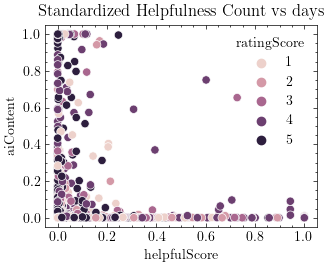


Results of the Spearman test: Correlation is 0.22331170982995377, with a p-value of 0.00000.
days and helpfulScore are correlated.

Results of the Kendall Tau test: Correlation is 0.152716840879164, with a p-value of 0.00000.
days and helpfulScore are correlated.

Results of the Pearson test: Correlation is 0.07891476137622985, with a p-value of 0.00028.
days and helpfulScore are correlated.


In [8]:
# 4. getting the days feature
df['days'] = pd.to_datetime('2023-08-21') - df['date']
df['days'] = df['days'].dt.days
# 5. statistical and visual analysis
numerical_testing(df, 'helpfulScore', col_2='days')

In [9]:
# 6. modelling with aiContent and days

import pandas as pd
import statsmodels.api as sm

# Create the OLS model
X = df[['days', 'aiContent']]  
y = df['helpfulScore']       
X = sm.add_constant(X)
model = sm.OLS(y, X)

# Fit the model and print the summary statistics
print(model.fit().summary())


                            OLS Regression Results                            
Dep. Variable:           helpfulScore   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     9.654
Date:                Tue, 12 Sep 2023   Prob (F-statistic):           6.70e-05
Time:                        19:45:07   Log-Likelihood:                 747.23
No. Observations:                2120   AIC:                            -1488.
Df Residuals:                    2117   BIC:                            -1471.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0668      0.005     14.152      0.0

### Analysis and Summary of Findings:

* The statistical tests and the visualization show that there is a statistically significant but quantitatively small negative correlation between the helpfulness of a review and its AI Content.
* There is also a statistically signficant correlation with `days`, the age of the Review.
* However this is relatively small compared to the negative correlation to `aiContent`.



## What is the trend of aiContent volume since Chat GPT launch?

This experiment observes the trend of aiContent volume prior to and after the launch of Chat GPT Launch.

### Process:
1. The `aiContent` numerical feature is converted into a binary feature of the same name: 0 for less than 50% and 1 for greater than 50%.
2. The average annual `aiContent` for the past 4 years was aggregated and standardized (to compensate for any class variations) and visualized.

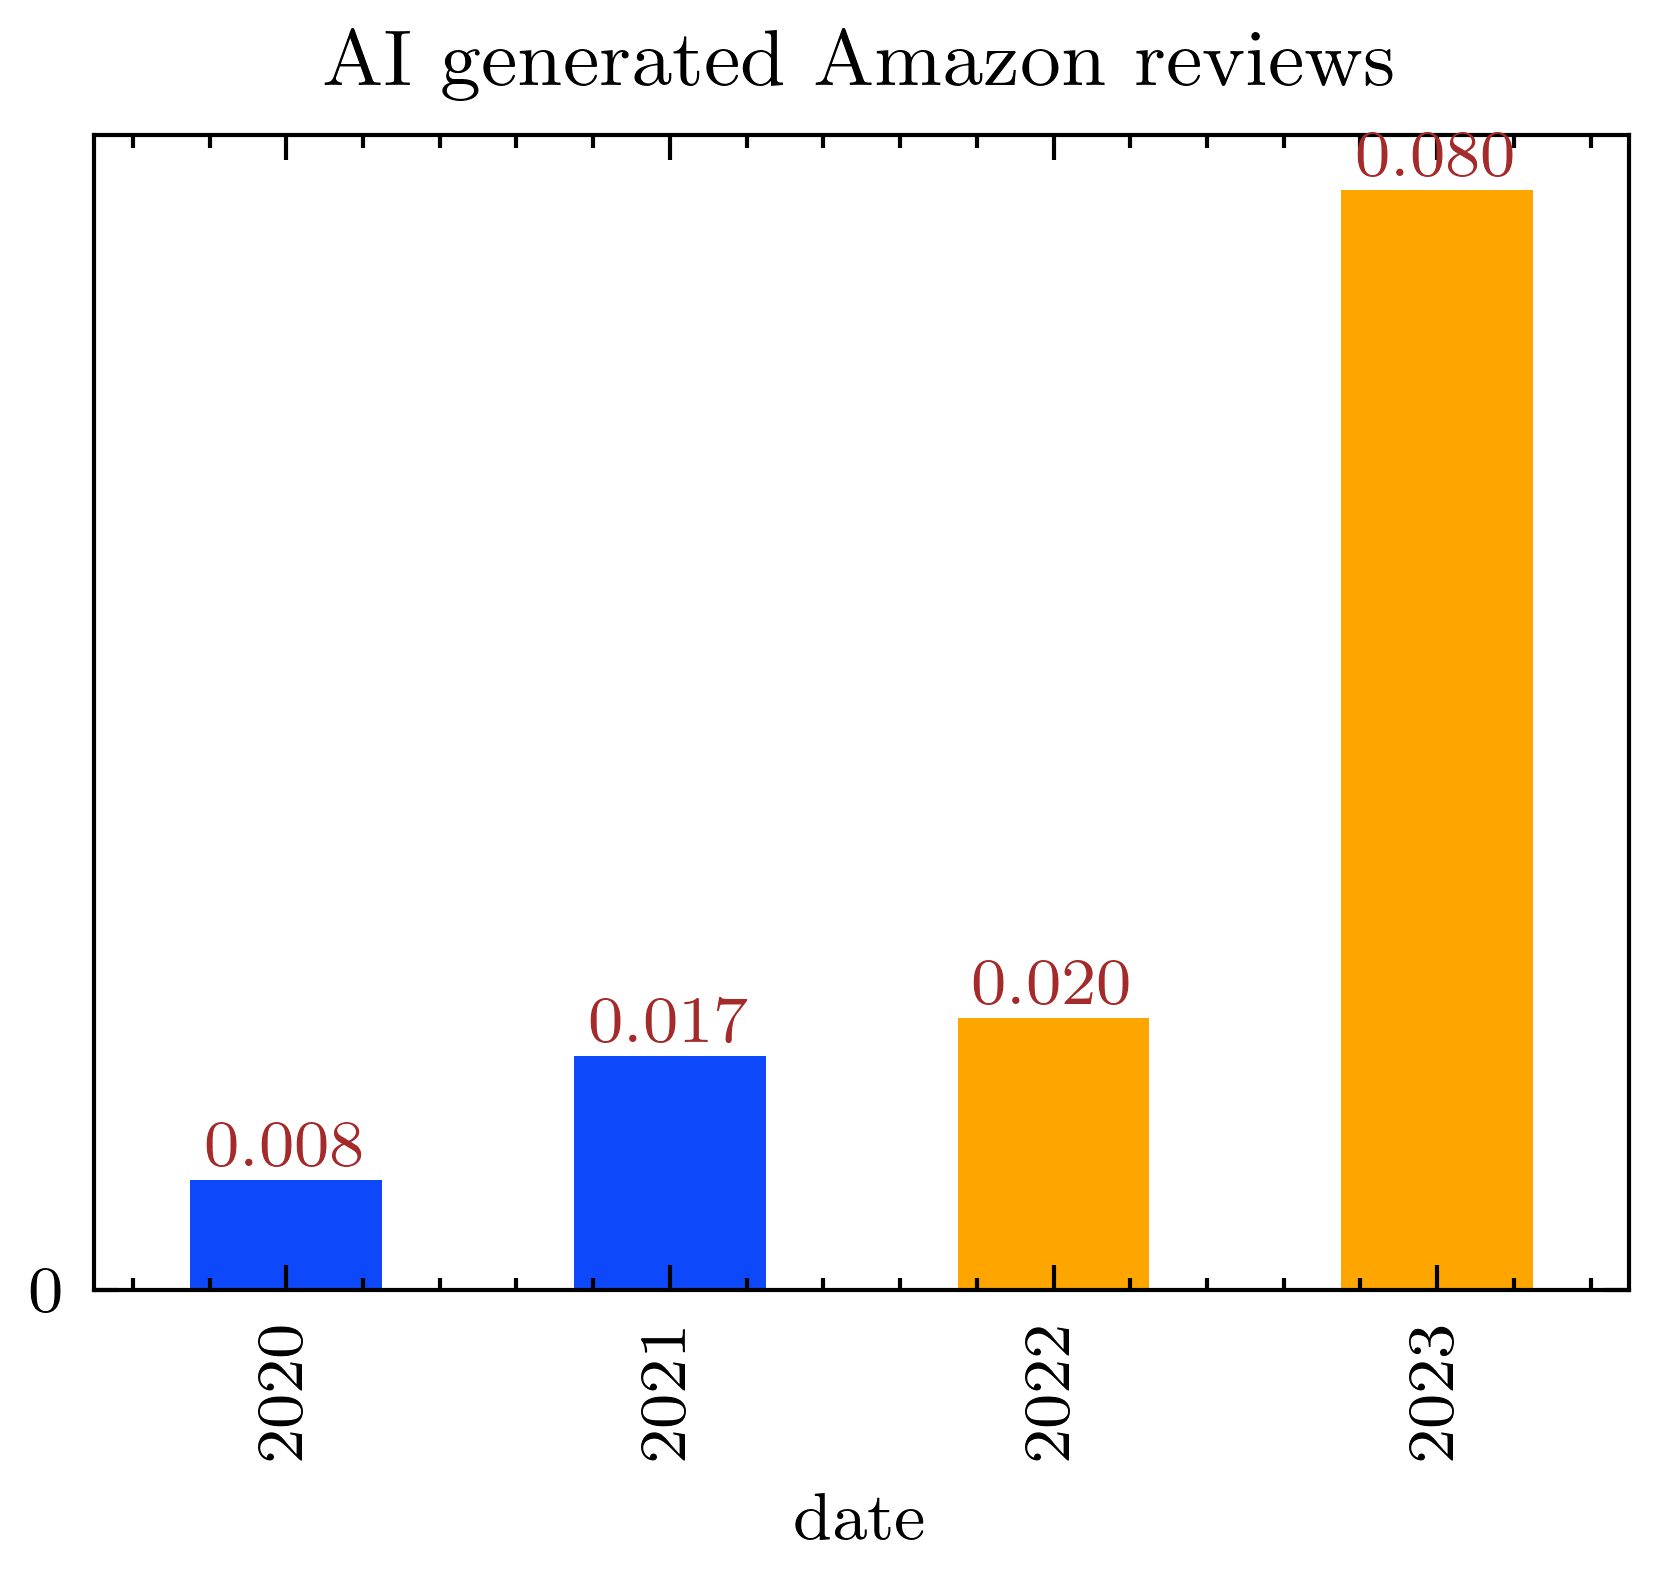

In [10]:
df.aiContent = df.aiContent.apply(lambda x: 1 if x>0.5 else 0 if x < 0.5 else None)
time_df = generate_df_plot(df, start='2020') # returns this as a timeseries

### Summary of Findings

* In 2023, the annual average `aiContent` increased by approximately 4 times its value from the previous year. Chat GPT was launched in December 2022.

# Appendix

## Checking sample to population distribution

In order to generalize the results we get from analyzing the subset `df` of ~2K records to the set of 27K records collected, we need to confirm if it represents the same distribution.

Note that: this only generalizes to the larger dataset, not to the entire corpus of Amazon reviews as that dataset is not available to the public.

### Process:

1. Visual analysis: plotting the bargraphs of the distributions.
2. Statistical analysis: the KS and Chisquare power divergence tests.

Population size is 26606.
Sample size is 2120.
The sample is 8.0% of the population.


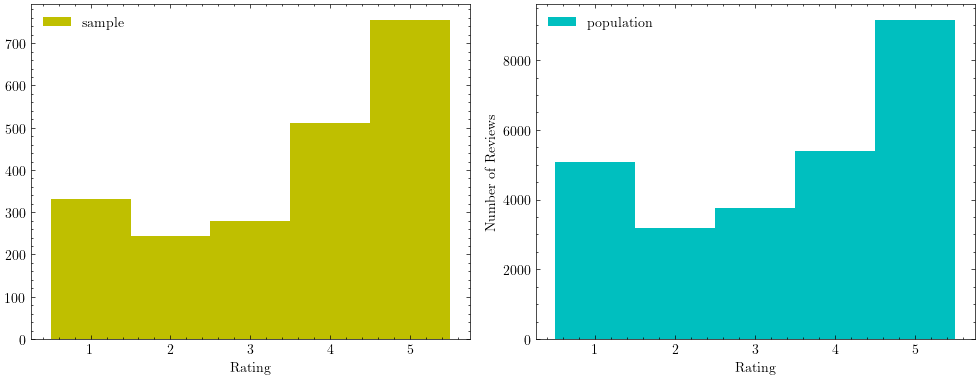

In [11]:
df_population = get_raw_data()
df_population.date = pd.to_datetime(df_population.date)
df_sample = get_data_for_analysis()
print(f"Population size is {len(df_population)}.")
print(f"Sample size is {len(df_sample)}.")
print(f"The sample is {len(df_sample)/len(df_population)*100:.1f}% of the population.")

# extract ratingScore from both distributions
sample = df_sample.ratingScore
population = df_population.ratingScore

dists = [sample, population]
titles = ['sample', 'population']
colors = ['y','c']

# plot the bar graphs and extract the frequency distribution for statistics testing
counts_for_testing = plotbars(dists, titles, colors)


In [12]:
# statistics testing
from scipy.stats import ks_2samp, chisquare, entropy
# normalize the distributions
x = counts_for_testing[0]/counts_for_testing[0].sum()
y = counts_for_testing[1]/counts_for_testing[1].sum()

display(ks_2samp(x, y))
display(chisquare(x, y))
kld = entropy(x, y)
print("KullbackLeibler divergence",kld)

KstestResult(statistic=0.2, pvalue=1.0)

Power_divergenceResult(statistic=0.014470015882709726, pvalue=0.9999739532278498)

KullbackLeibler divergence 0.007250978317268229


### Summary of Findings

Visual Analysis: The two distributions are very similar. With very close examining, one will only notice that Rating '4' has a small delta across the 2 distributions. 

The null hypothesis or prevailing assumption of KS and Chisquare tests is that these two distributions are  the same, and therefore represent samples from the same source. For this to be challenged, the p-values of these tests should be less than 0.05, which is the usual value set for alpha - the level of statistical significance. 

As observed, they both have p-values > 0.05, showing that the Hypothesis that these the sample subset is representative of the population of raw data, can be assumed.

KLD measures how much one distribution differs from the other. The low KLD score (<0.01) indicates that the two distributions are very similar, which corresponds with the other statistics tests. 

